## Human Activity Recognition

This notebook contains the code for processing the MotionSense dataset using AI and Machine Learning.

## 1. Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset


## 2. Dataset Loading and Sensor Column Setup

This code facilitates data loading. It reads CSV files using get_ds_infos() and set_data_types todefine the sensor columns.

In [3]:
# Step 1: Load Subject Information
def get_ds_infos():
    return pd.read_csv("./data/data_subjects_info.csv")

# Step 2: Define sensor columns
def set_data_types(data_types=["userAcceleration"]):
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])
    return dt_list


## 3. Dataset Construction from Raw Files
create_time_series() combines sensor data (attitude, userAcceleration) and creates a time series.

In [4]:
# Step 3: Create Time-Series from raw data
def create_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=True):
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list*3)

    if labeled:
        dataset = np.zeros((0,num_data_cols+1)) # "1" --> [act] we do not need the other labels
    else:
        dataset = np.zeros((0,num_data_cols))
        
    ds_list = get_ds_infos()
    
    print("[INFO] -- Creating Time-Series")
    for sub_id in ds_list["code"]:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act_id]:
                fname = './data/A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:,x_id] = (raw_data[axes]**2).sum(axis=1)**0.5        
                    else:
                        vals[:,x_id*3:(x_id+1)*3] = raw_data[axes].values
                    vals = vals[:,:num_data_cols]
                if labeled:
                    lbls = np.array([[act_id]]*len(raw_data))
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset,vals, axis=0)
    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]
            
    if labeled:
        cols += ["act"]
    
    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset

## 4. Activities
The following code defines activities and trials 

In [21]:
# Step 5:
ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13]
}

## Here we set parameter to build labeled time-series from dataset of "(A)DeviceMotion_data"
## attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
sdt = ["attitude", "userAcceleration"]
print("[INFO] -- Selected sensor data types: "+str(sdt))    
act_labels = ACT_LABELS [0:6]
print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = set_data_types(sdt)
dataset = create_time_series(dt_list, act_labels, trial_codes, mode="raw", labeled=True)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))    
dataset.head()

[INFO] -- Selected sensor data types: ['attitude', 'userAcceleration']
[INFO] -- Selected activites: ['dws', 'ups', 'wlk', 'jog', 'std', 'sit']
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(1412865, 7)


,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,act
0,1.528132,-0.733896,0.696372,0.294894,-0.184493,0.377542,0.0
1,1.527992,-0.716987,0.677762,0.219405,0.035846,0.114866,0.0
2,1.527765,-0.706999,0.670951,0.010714,0.134701,-0.167808,0.0
3,1.516768,-0.704678,0.675735,-0.008389,0.136788,0.094958,0.0
4,1.493941,-0.703918,0.672994,0.199441,0.353996,-0.044299,0.0


# Data Pre-processing

## 6. Data Windowing and feacture extraction

In [22]:
# Windowing function
def windows(dataset, window_size=100, stride=50):
    windows_list = []
    labels_list = []
    for act_id, group in dataset.groupby('act'):
        data = group.drop('act', axis=1).values
        for start in range(0, len(data) - window_size + 1, stride):
            end = start + window_size
            windows_list.append(data[start:end])
            labels_list.append(act_id)
    return np.stack(windows_list).astype(np.float32), np.array(labels_list).astype(np.int64)

# Prepare windowed data
X, y = windows(dataset, window_size=100, stride=50)
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, test_size=0.2, val_size=0.1, random_state=42)
train_data = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_data = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
test_data = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


## 5. Train/Validation/Test Split

In [23]:
# Utility to split train/val/test
def train_val_test_split(X, y, test_size=0.2, val_size=0.1, random_state=None):
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    val_ratio = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_ratio, random_state=random_state, stratify=y_temp)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Models
Class definitions for the Random Forest, LSTM and the pre train ---- Model.

In [24]:

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out


# Training and Evaluation

Epoch 1/100, Training Loss: 418.9895, Validation Loss: 51.5007
Epoch 2/100, Training Loss: 267.5546, Validation Loss: 39.1118
Epoch 3/100, Training Loss: 227.5730, Validation Loss: 27.8639
Epoch 4/100, Training Loss: 170.9759, Validation Loss: 21.8382
Epoch 5/100, Training Loss: 133.6446, Validation Loss: 17.3203
Epoch 6/100, Training Loss: 117.4797, Validation Loss: 16.9654
Epoch 7/100, Training Loss: 109.4221, Validation Loss: 14.3308
Epoch 8/100, Training Loss: 101.7172, Validation Loss: 11.9212
Epoch 9/100, Training Loss: 81.4613, Validation Loss: 11.4705
Epoch 10/100, Training Loss: 74.2329, Validation Loss: 10.1021
Epoch 11/100, Training Loss: 66.9037, Validation Loss: 10.8565
Epoch 12/100, Training Loss: 68.4156, Validation Loss: 9.2057
Epoch 13/100, Training Loss: 69.3295, Validation Loss: 7.2965
Epoch 14/100, Training Loss: 69.4587, Validation Loss: 7.1720
Epoch 15/100, Training Loss: 52.2775, Validation Loss: 6.7360
Epoch 16/100, Training Loss: 46.1585, Validation Loss: 6.313

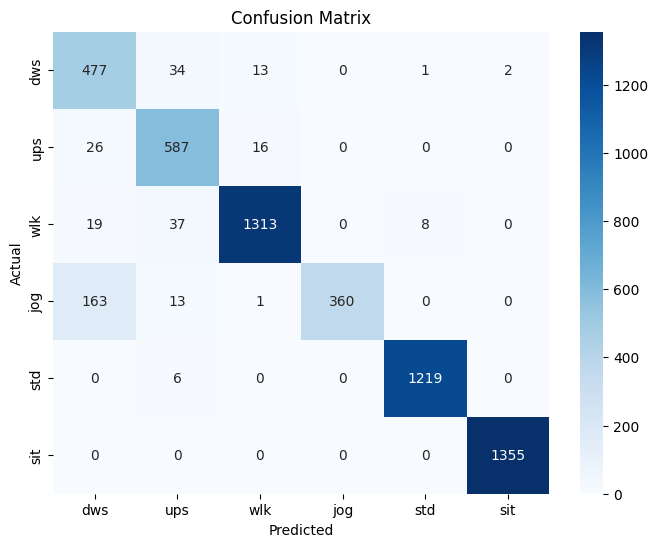

In [26]:
# Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(input_size=X.shape[2], hidden_size=64, num_layers=1, num_classes=len(np.unique(y))).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with early stopping
epochs = 100
patience = 5
best_val_loss = float('inf')
counter = 0

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {total_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Evaluation on test set
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Print metrics
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=act_labels))
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("Precision:", precision_score(all_labels, all_preds, average='weighted'))
print("Recall:", recall_score(all_labels, all_preds, average='weighted'))
print("F1 Score:", f1_score(all_labels, all_preds, average='weighted'))

# Confusion matrix heatmap
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=act_labels, yticklabels=act_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [27]:
print(model)

LSTMClassifier(
  (lstm): LSTM(6, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)


In [28]:
from torchinfo import summary
summary(model, input_size=(64, X.shape[1], X.shape[2]), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
LSTMClassifier                           [64, 6]                   --
├─LSTM: 1-1                              [64, 100, 64]             18,432
├─Linear: 1-2                            [64, 6]                   390
Total params: 18,822
Trainable params: 18,822
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 117.99
Input size (MB): 0.15
Forward/backward pass size (MB): 3.28
Params size (MB): 0.08
Estimated Total Size (MB): 3.51